In [7]:
from google.colab import files
uploaded = files.upload()


Saving sent_gnss.csv to sent_gnss (1).csv


In [3]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# Veriyi okuma
df = pd.read_csv("Data/sent_gnss.csv")
all_points = df[['latitude', 'longitude']].values
junctions = df[df['junction'] == 1.0][['latitude', 'longitude']].reset_index(drop=True)
other_points = df[df['junction'] == 0.0][['latitude', 'longitude']].reset_index(drop=True)[['latitude', 'longitude']].values

junction_coords = junctions.values

# Parametreler
search_radius = 0.0001
angle_thresh = np.pi / 1
max_steps = 1000

# Yardımcı fonksiyonlar
def angle_between(v1, v2):
    unit_v1 = v1 / np.linalg.norm(v1) if np.linalg.norm(v1) else v1
    unit_v2 = v2 / np.linalg.norm(v2) if np.linalg.norm(v2) else v2
    dot = np.dot(unit_v1, unit_v2)
    return np.arccos(np.clip(dot, -1.0, 1.0))

def follow_path_by_angle(start_point, other_points, visited, junction_coords,
                         max_steps=100, angle_thresh=np.pi/4, dist_thresh=0.0003):
    path = [start_point]
    current = start_point
    prev = start_point
    steps = 0

    while steps < max_steps:
        steps += 1

        candidates = [p for p in other_points if  np.linalg.norm(p - current) < dist_thresh] #(tuple(p) not in visited) and
        if not candidates:
            print("\tNo candidates found within distance threshold.")
            break

        best_point = None
        best_angle = np.pi
        for cand in candidates:
            v1 = current - prev
            v2 = cand - current
            angle = angle_between(v1, v2)
            if angle < angle_thresh and angle < best_angle:
                best_angle = angle
                best_point = cand

        if best_point is None:
            print("\tNo suitable point found within angle threshold.")
            break

        visited.add(tuple(best_point))
        path.append(best_point)
        prev = current
        current = best_point

        # Junction'a ulaştı mı?
        for j_idx, junc in enumerate(junction_coords):
            if np.linalg.norm(current - junc) < dist_thresh and not np.array_equal(junc, start_point):
                return path, j_idx

    return None, None

# Graphı başlat
G = nx.Graph()
for idx, coord in enumerate(junction_coords):
    G.add_node(idx, pos=(coord[1], coord[0]))  # (lon, lat)

# Junctionlardan yol başlat
visited_points = set()
for j_idx, junc in enumerate(junction_coords):
    # Junction yakınındaki bir nokta bulma
    for point in other_points:
        if np.linalg.norm(point - junc) < search_radius and (tuple(point) not in visited_points):
            print(f"Starting path from junction {j_idx} at {point}")
            visited_points.add(tuple(point))
            path, end_junc_idx = follow_path_by_angle(point, other_points, visited_points,
                                                      junction_coords, max_steps, angle_thresh, search_radius)
            if (path is not None) and (end_junc_idx is not None):
                print(f"\tPath found from junction {j_idx} to junction {end_junc_idx}: {path}")
                G.add_edge(j_idx, end_junc_idx)


Starting path from junction 0 at [-0.001    0.00175]
Starting path from junction 0 at [-0.001   0.0017]
	Path found from junction 0 to junction 0: [array([-0.001 ,  0.0017]), array([-0.001  ,  0.00175])]
Starting path from junction 0 at [-0.00105  0.00175]
	Path found from junction 0 to junction 0: [array([-0.00105,  0.00175]), array([-0.001  ,  0.00175])]
Starting path from junction 1 at [-0.00175  0.00175]
Starting path from junction 1 at [-0.0018   0.00175]
	Path found from junction 1 to junction 1: [array([-0.0018 ,  0.00175]), array([-0.00175,  0.00175])]
Starting path from junction 1 at [-0.0017   0.00175]
	Path found from junction 1 to junction 1: [array([-0.0017 ,  0.00175]), array([-0.00175,  0.00175])]
Starting path from junction 1 at [-0.00175  0.0017 ]
	Path found from junction 1 to junction 1: [array([-0.00175,  0.0017 ]), array([-0.00175,  0.00175])]
Starting path from junction 2 at [-0.00215  0.00175]
Starting path from junction 2 at [-0.0021   0.00175]
	Path found from 

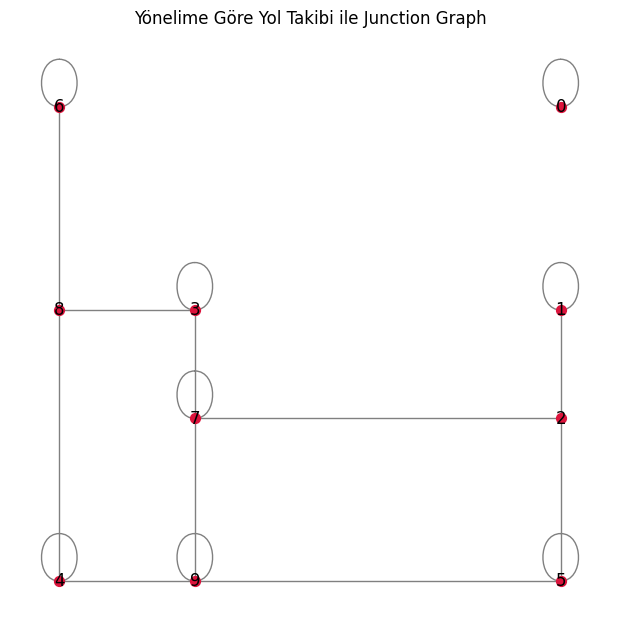

In [4]:
# Grafı çiz
pos = nx.get_node_attributes(G, 'pos')
plt.figure(figsize=(6, 6))
nx.draw(G, pos, node_size=50, node_color='crimson', edge_color='gray', with_labels=True)
plt.title("Yönelime Göre Yol Takibi ile Junction Graph")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.axis("equal")
plt.show()
